<a href="https://colab.research.google.com/gist/gretahartm/bb8a24576a4773aef721f170a3601aab/8notebooksb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Evalute model performance

In [1]:
!pip install albumentations==1.3.0
!git clone https://github.com/kevin-allen/unetTracker
!pip install -r unetTracker/requirements.txt
!pip install -e unetTracker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 7.2 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.20
    Uninstalling albumentations-1.4.20:
      Successfully uninstalled albumentations-1.4.20
Cloning into 'unetTracker'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (401/401), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 1022 (delta 233), reused 353 (delta 204), pack-reused 621 (from 1)
Receiving objects: 100% (1022/1022), 127.56 MiB | 17.81 MiB/s, done.
Resolving deltas: 100% (623/623), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

fn = "/content/drive/My Drive/ssfolder"
if os.path.exists(fn):
  print("We can access the ssfolder directory.")
else:
  raise IOError("Problem accessing the ssfolder directory.")

Mounted at /content/drive
We can access the ssfolder directory.


In [3]:
# this will run the code in the setup_project.py and create a variable called `project`
fn = "/content/drive/My Drive/ssfolder/setup_project.py"
if os.path.exists(fn):
  print("We can access the file.")
else:
  raise IOError("Problem accessing the file.")

%run "/content/drive/My Drive/ssfolder/setup_project.py"

We can access the file.
Project directory: /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker
Getting configuration from config file. Values from config file will be used.
Loading /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/config.yalm
{'augmentation_HorizontalFlipProb': 0.5, 'augmentation_RandomBrightnessContrastProb': 0.2, 'augmentation_RandomSizedCropProb': 1.0, 'augmentation_RotateProb': 0.3, 'image_extension': '.png', 'image_size': [270, 480], 'labeling_ImageEnlargeFactor': 2.0, 'name': 'simonebiles_tracker', 'normalization_values': {'means': [0.1952759027481079, 0.15899455547332764, 0.13951754570007324], 'stds': [0.16387943923473358, 0.16304421424865723, 0.16733983159065247]}, 'object_colors': [(240.0, 248.0, 255.0), (250.0, 235.0, 215.0), (0.0, 255.0, 255.0), (127.0, 255.0, 212.0), (240.0, 255.0, 255.0), (245.0, 245.0, 220.0), (255.0, 228.0, 196.0), (0.0, 0.0, 0.0), (255.0, 235.0, 205.0), (0.0, 0.0, 255.0)], 'objects': ['head', 'right

In [4]:
import torch
from torch.utils.data import DataLoader


from unetTracker.trackingProject import TrackingProject
from unetTracker.dataset import UNetDataset
from unetTracker.unet import Unet
from unetTracker.coordinatesFromSegmentationMask import CoordinatesFromSegmentationMask

In [5]:
TRAIN_IMAGE_DIR = os.path.join(project.dataset_dir,"train_images")
TRAIN_MASK_DIR =  os.path.join(project.dataset_dir,"train_masks")
TRAIN_COORDINATE_DIR = os.path.join(project.dataset_dir,"train_coordinates")
VAL_IMAGE_DIR = os.path.join(project.dataset_dir,"val_images")
VAL_MASK_DIR =  os.path.join(project.dataset_dir,"val_masks")
VAL_COORDINATE_DIR = os.path.join(project.dataset_dir,"val_coordinates")



DEVICE = (torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
BATCH_SIZE = 2
NUM_WORKERS = 2
PIN_MEMORY=False

In [6]:
fileName = os.path.join(project.augmentation_dir,"valTransform")
print("Loading valTransform from", fileName)
valTransform=pickle.load(open(fileName, "rb" ))
print(valTransform)

Loading valTransform from /content/drive/My Drive/ssfolder/trackingProjects/simonebiles_tracker/augmentation/valTransform
Compose([
  Normalize(always_apply=False, p=1.0, mean=[0.1952759027481079, 0.15899455547332764, 0.13951754570007324], std=[0.16387943923473358, 0.16304421424865723, 0.16733983159065247], max_pixel_value=255.0),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [7]:
valDataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=valTransform)
trainDataset = UNetDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR,TRAIN_COORDINATE_DIR, transform=valTransform) # use same transform as for val
dataset = UNetDataset(VAL_IMAGE_DIR, VAL_MASK_DIR,VAL_COORDINATE_DIR, transform=None)

valLoader = DataLoader(valDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)
trainLoader = DataLoader(trainDataset,shuffle=False,batch_size=BATCH_SIZE, num_workers=NUM_WORKERS,pin_memory = PIN_MEMORY)

In [8]:
model = Unet(in_channels=3, out_channels=len(project.object_list)).to(DEVICE)
project.load_model(model)
a = model.eval()

/content/drive/My Drive/ssfolder/unetTracker/trackingProject.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(self.model_fn))


In [9]:
len(trainDataset)

140

In [10]:
imageIndex=1
image,mask,coord = valDataset[imageIndex]
imageOri,_,_ =dataset[imageIndex]

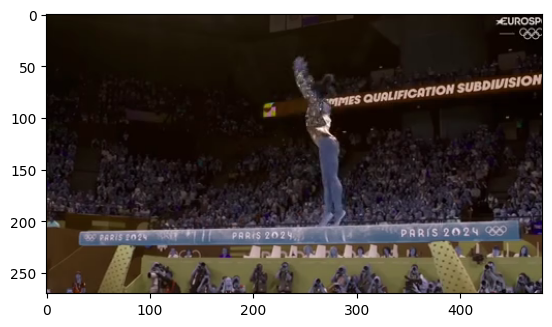

In [11]:
imageOri =imageOri.permute(1,2,0).numpy()
imageOri = imageOri.astype(np.uint8)
plt.imshow(imageOri)

In [12]:
cDetector = CoordinatesFromSegmentationMask()

In [13]:
from unetTracker.utils import check_accuracy

In [14]:
check_accuracy(model,valLoader,DEVICE)

Number of positive pixels predicted: 6020.0
Number of positive pixels in masks: 8190.0
Percentage of positive pixels predicted: 0.024
Percentage of positive pixels in masks: 0.033
Accuracy: 99.963
Dice score: 0.359
Mask pixels detected (True positives): 31.294%
False positives: 57.425%
Mean distance: 5.400966458665585


In [15]:
check_accuracy(model,trainLoader,DEVICE)

Number of positive pixels predicted: 62364.0
Number of positive pixels in masks: 60745.0
Percentage of positive pixels predicted: 0.034
Percentage of positive pixels in masks: 0.033
Accuracy: 99.990
Dice score: 0.853
Mask pixels detected (True positives): 86.531%
False positives: 15.716%
Mean distance: 0.9459048564967816
